## PHẦN 1: CÀI ĐẶT, IMPORTS & THIẾT LẬP BAN ĐẦU

In [1]:
# ==============================================================================
# CELL 1.1: CÀI ĐẶT THƯ VIỆN & BIẾN MÔI TRƯỜNG (CẬP NHẬT)
# ==============================================================================
import os
import json
import asyncio
import operator
import time 
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union

# Tải các biến môi trường
from dotenv import load_dotenv 
load_dotenv()

# LangChain & LangGraph
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.pydantic_v1 import BaseModel, Field
# --- NÂNG CẤP: Chuyển sang thư viện Google Generative AI (dành cho AI Studio) ---
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages

# --- NÂNG CẤP: Thêm công cụ tìm kiếm ---
from langchain_community.tools.tavily_search import TavilySearchResults

# Thư viện hỗ trợ & Kho tri thức
from langchain_community.vectorstores import FAISS
from langchain_huggingface import HuggingFaceEmbeddings
from rich.console import Console
from rich.markdown import Markdown
from rich.pretty import pprint
from IPython.display import Image, display

c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\IPython\core\interactiveshell.py:3699: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
# ==============================================================================
# CELL 1.2: CẤU HÌNH LOG & CÁC HÀM IN ẤN
# ==============================================================================
from langchain_groq import ChatGroq
# --- CẤU HÌNH LOG ---
VERBOSE_MODE = True

# --- KHỞI TẠO CÁC CÔNG CỤ IN ẤN ---
console = Console()

def print_step(message: str):
    if VERBOSE_MODE:
        console.print(f"\n[bold cyan]>[/bold cyan] {message}")

def print_result(data: Any, title: str = "Kết quả"):
    if VERBOSE_MODE:
        console.print(f"[bold green]✔️ {title}:[/bold green]")
        pprint(data, expand_all=True)
        
def print_warning(message: str):
    if VERBOSE_MODE:
        console.print(f"[bold yellow]⚠️  {message}[/bold yellow]")

In [4]:
# ==============================================================================
# CELL 1.3: KHỞI TẠO LLM (NÂNG CẤP SANG GOOGLE AI STUDIO)
# ==============================================================================
try:
    llm = ChatGoogleGenerativeAI(
        model="gemini-2.5-flash", # Sử dụng model mới nhất và mạnh nhất
        temperature=0.1,
        google_api_key=os.getenv("GOOGLE_API_KEY")
    )
    print("✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.")
except Exception as e:
    print(f"❌ LỖI: Không thể khởi tạo LLM. Hãy chắc chắn bạn đã cài 'langchain-google-genai' và có GOOGLE_API_KEY trong file .env. Lỗi: {e}")
    llm = None

✅ LLM (Gemini 2.5 Flash từ Google AI Studio) đã được khởi tạo thành công.


## PHẦN 2: ĐỊNH NGHĨA STATE CỦA HỆ THỐNG


In [14]:
# ==============================================================================
# CELL 1.4: TẢI KHO TRI THỨC (RAG)
# ==============================================================================
# --- TẢI KHO TRI THỨC ---
BASE_VECTOR_STORE_PATH = "vector_store"
vector_store = None
embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

if os.path.exists(BASE_VECTOR_STORE_PATH):
    subdirectories = [f.path for f in os.scandir(BASE_VECTOR_STORE_PATH) if f.is_dir()]
    if not subdirectories:
        print(f"❌ LỖI: Không tìm thấy thư mục con nào trong '{BASE_VECTOR_STORE_PATH}'.")
    else:
        try:
            print_step(f"Đang tải và hợp nhất các kho tri thức từ {len(subdirectories)} thư mục...")
            # Tải kho tri thức đầu tiên để làm cơ sở
            first_store_path = subdirectories.pop(0)
            vector_store = FAISS.load_local(first_store_path, embeddings, allow_dangerous_deserialization=True)
            print(f"✅ Đã tải thành công kho tri thức cơ sở: '{os.path.basename(first_store_path)}'")

            # Hợp nhất các kho tri thức còn lại
            for store_path in subdirectories:
                if os.path.exists(os.path.join(store_path, "index.faiss")):
                    temp_store = FAISS.load_local(store_path, embeddings, allow_dangerous_deserialization=True)
                    vector_store.merge_from(temp_store)
                    print(f"✅ Đã hợp nhất thành công: '{os.path.basename(store_path)}'")
                else:
                    print_warning(f"Bỏ qua thư mục '{os.path.basename(store_path)}' vì không chứa file index.faiss.")
            
            print("\n[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]")

        except Exception as e:
            print(f"❌ LỖI trong quá trình tải hoặc hợp nhất kho tri thức: {e}")
else:
    print(f"❌ LỖI: Không tìm thấy thư mục gốc của kho tri thức tại '{BASE_VECTOR_STORE_PATH}'.")


c:\Users\Hi\Documents\IAI - UET\AI-Lesson-Plan-Generator\plan_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


> Đang tải và hợp nhất các kho tri thức từ 2 thư mục...

✅ Đã tải thành công kho tri thức cơ sở: 'sgk_toan_12_1'
✅ Đã hợp nhất thành công: 'sgk_toan_9'

[bold green]✔️ Tất cả các kho tri thức RAG đã được tải và hợp nhất thành công.[/bold green]


In [15]:
# ==============================================================================
# CELL 2.1: ĐỊNH NGHĨA STATE NÂNG CAO (v9.0)
# ==============================================================================
from typing import TypedDict, Annotated, List, Dict, Any, Literal, Optional, Union
from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
import operator

# --- Hàm tiện ích (giữ nguyên) ---
def merge_dicts(dict1: Dict[str, Any], dict2: Dict[str, Any]) -> Dict[str, Any]:
    merged = dict1.copy()
    for key, value in dict2.items():
        if key in merged and isinstance(merged[key], dict) and isinstance(value, dict):
            merged[key] = merge_dicts(merged[key], value)
        else:
            merged[key] = value
    return merged

# --- Cấu trúc dữ liệu con (giữ nguyên) ---
class DetailedTask(TypedDict):
    task_id: int
    task_name: str
    task_description: str
    estimated_duration: int 
    status: Literal["pending", "completed"]

# === NÂNG CẤP V9.0: CÁC CẤU TRÚC DỮ LIỆU MỚI CHO TƯ DUY SÂU ===
class DifferentiatedInstruction(TypedDict):
    """Gợi ý cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str
    for_advanced_students: str

class StructuredContentItem(TypedDict):
    """Định nghĩa một hoạt động hoặc đánh giá có cấu trúc."""
    task_id: int
    activity_name: str
    question_or_description: str # Gộp 'question' và 'description'
    duration_minutes: int
    content_type: str # Gộp 'activity_type' và 'question_type'
    teacher_actions: List[str]
    solution_guide: Any
    answer: Optional[str] # Dành cho câu hỏi đánh giá
    differentiation: Optional[DifferentiatedInstruction]

class FinalStructuredPlan(TypedDict):
    """Định nghĩa cấu trúc JSON cho giáo án cuối cùng."""
    general_info: Dict[str, Any]
    learning_objectives: List[str]
    preparation: Dict[str, List[str]]
    knowledge_summary: str
    lesson_flow: List[StructuredContentItem]
    # pedagogical_explainer: Dict[str, Any] # Dành cho nâng cấp tương lai

# === NÂNG CẤP V9.0: STATE MỚI VỚI CÁC TRƯỜNG TRÍ TUỆ MỚI ===
class TeacherStateV5(TypedDict):
    # Các trường cơ bản
    original_request: str
    messages: Annotated[List[BaseMessage], add_messages]
    domain: Optional[str]
    
    # === NÂNG CẤP: student_persona giờ sẽ chứa cả chiến lược phân hóa ===
    student_persona: Optional[Dict[str, Any]] 
    
    # Các bước tuần tự ban đầu
    analyzed_objective: Optional[Any]
    pedagogy_strategy: Optional[Any]
    pedagogical_blueprint: Optional[List[str]]

    # Các trường nâng cao
    expanded_queries: Optional[List[str]]
    task_list: Optional[List[DetailedTask]]
    current_task_id: Optional[int]
    reflection_notes: Optional[str]
    agent_outputs: Annotated[Dict[str, Any], merge_dicts] 
    next_agent: str
    
    # Các trường tạm thời cho vòng lặp kiểm duyệt vi mô (Micro-loop)
    current_content_to_validate: Optional[Dict[str, Any]]
    validation_feedback: Optional[str]

    # === NÂNG CẤP: Output cuối cùng sẽ có 2 dạng ===
    final_structured_plan: Optional[FinalStructuredPlan] # Dạng JSON có cấu trúc
    final_markdown_plan: Optional[str] # Dạng Markdown để hiển thị

print("✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.")

✅ 'TeacherStateV5' (v9.0 - Hỗ trợ Phân hóa & Cấu trúc) đã được định nghĩa.


In [16]:
# ==============================================================================
# CELL 2.2: NODE KHỞI TẠO STATE
# ==============================================================================
def initialize_state_node(state: TeacherStateV5) -> Dict[str, Any]:
    """
    Node đầu tiên trong graph.
    Lấy yêu cầu gốc từ tin nhắn đầu vào và điền vào trường 'original_request'.
    """
    print_step("`Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...")
    user_request = state['messages'][-1].content
    return {"original_request": user_request}

print("✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.")

✅ Node khởi tạo 'initialize_state_node' đã được định nghĩa.


## PHẦN 3: ĐỊNH NGHĨA CÁC AGENT

In [34]:
# ==============================================================================
# CELL 3.1: HÀM TIỆN ÍCH, PERSONA & CÁC CẤU TRÚC DỮ LIỆU (NÂNG CẤP V9.0)
# ==============================================================================
import json
from langchain_core.pydantic_v1 import BaseModel, Field, schema_json_of
from typing import List, Dict, Any, Literal, Optional

# --- HÀM TIỆN ÍCH & PERSONA (giữ nguyên) ---
def format_solution_guide(guide: Any) -> str:
    if not guide: return "Chưa có hướng dẫn."
    if isinstance(guide, str): return guide
    if isinstance(guide, list): return "\n".join(f"- {step}" for step in guide)
    if isinstance(guide, dict): return "\n".join(f"- {key.replace('_', ' ').title()}: {value}" for key, value in guide.items())
    return str(guide)

def format_teacher_actions(actions: Optional[List[str]]) -> str:
    if not actions: return "Giáo viên quan sát và hỗ trợ chung."
    return "\n".join(f"  - {action}" for action in actions)

def update_agent_outputs(state: "TeacherStateV5", key: str, value: Any) -> Dict[str, Any]:
    outputs = state.get("agent_outputs", {}).copy()
    if key not in outputs: outputs[key] = []
    outputs[key].append(value)
    return {"agent_outputs": outputs}

SYSTEM_PERSONA_PROMPT = "BẠN LÀ MỘT TRỢ LÝ AI CHUYÊN NGHIỆP, ĐÓNG VAI TRÒ MỘT GIÁO VIÊN GIÀU KINH NGHIỆM TẠI VIỆT NAM. LUÔN LUÔN trả lời bằng TIẾNG VIỆT."

# === NÂNG CẤP V9.0: PYDANTIC MODELS MỚI CHO TƯ DUY SÂU ===

class DifferentiatedInstructionModel(BaseModel):
    """Gợi ý cụ thể cho việc dạy học phân hóa trong một hoạt động."""
    for_struggling_students: str = Field(description="Một gợi ý hoạt động, câu hỏi, hoặc sự hỗ trợ cụ thể cho nhóm học sinh yếu/gặp khó khăn.")
    for_advanced_students: str = Field(description="Một câu hỏi mở rộng, một thử thách, hoặc một hoạt động nâng cao cho nhóm học sinh giỏi.")

class LearningActivity(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động học tập. Ví dụ: 'Thảo luận nhóm về ứng dụng của Tích phân'")
    description: str = Field(description="Mô tả chi tiết các bước HỌC SINH cần làm.")
    duration_minutes: int = Field(description="Thời gian ước tính (bằng SỐ PHÚT).")
    activity_type: str = Field(description="Phân loại hoạt động. Ví dụ: 'Thảo luận nhóm', 'Thực hành cá nhân'")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN trong hoạt động này.")
    solution_guide: Optional[Any] = Field(description="Hướng dẫn giải hoặc các câu hỏi gợi mở cụ thể cho học sinh.")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này.")

class AssessmentItem(BaseModel):
    activity_name: str = Field(description="Tên của hoạt động đánh giá. Ví dụ: 'Thử thách cuối bài'")
    question: str = Field(description="Nội dung câu hỏi hoặc đề bài toán cụ thể.")
    question_type: str = Field(description="Loại câu hỏi. Ví dụ: 'Tự luận', 'Trắc nghiệm'")
    teacher_actions: List[str] = Field(description="Danh sách các hành động CỤ THỂ của GIÁO VIÊN trong hoạt động này.")
    answer: str = Field(description="Đáp án chính xác và ngắn gọn.")
    solution_guide: Any = Field(description="Hướng dẫn giải chi tiết từng bước.")
    duration_minutes: int = Field(description="Thời gian ước tính (bằng SỐ PHÚT).")
    differentiation: Optional[DifferentiatedInstructionModel] = Field(description="Gợi ý phân hóa cụ thể cho hoạt động này, ví dụ một câu hỏi phụ khó hơn.")

class StudentPersona(BaseModel):
    learning_pace: Literal["nhanh", "trung bình", "chậm"] = Field(description="Tốc độ học tập chung của lớp.")
    engagement_style: Literal["chủ động", "thụ động", "hỗn hợp"] = Field(description="Mức độ tham gia chung của lớp.")
    special_notes: str = Field(description="Tóm tắt các đặc điểm nổi bật của lớp học.")

class StudentPersonaAndDifferentiation(StudentPersona):
    """Mở rộng StudentPersona để bao gồm cả chiến lược phân hóa tổng thể."""
    differentiation_strategy: DifferentiatedInstructionModel = Field(description="Chiến lược dạy học phân hóa tổng thể cho cả bài học dựa trên các đặc điểm của lớp.")

# --- Các model khác giữ nguyên ---
class DetailedTaskModel(BaseModel):
    task_name: str = Field(description="Tên của nhiệm vụ này.")
    task_description: str = Field(description="Mô tả chi tiết nhiệm vụ cần thực hiện.")
    estimated_duration: int = Field(description="Thời gian ước tính (bằng phút) cho nhiệm vụ này.")

class TaskListWithDuration(BaseModel):
    tasks: List[DetailedTaskModel]

class DetailedPedagogyChoice(BaseModel):
    name: str = Field(description="Tên của phương pháp sư phạm được chọn.")
    rationale: str = Field(description="Lý do tại sao phương pháp này phù hợp.")
    key_actions: List[str] = Field(description="Danh sách các hành động/hoạt động cốt lõi đặc trưng cho phương pháp này.")

class ValidationResult(BaseModel):
    is_valid: bool = Field(description="Nội dung có hợp lệ và chính xác về mặt chuyên môn không.")
    feedback: str = Field(description="Phản hồi chi tiết. Nếu không hợp lệ, hãy giải thích rõ ràng lỗi sai và gợi ý cách sửa.")

class Domain(BaseModel):
    domain: str = Field(description="Lĩnh vực học thuật chính của yêu cầu.")

class ExpandedQueries(BaseModel): queries: List[str]
class BestSnippets(BaseModel): best_snippets: List[str]
class ParsedObjective(BaseModel): action_verb: str; bloom_level: int; topic: str; grade_level: str; duration_minutes: Optional[int]
class TaskClassification(BaseModel): agent_category: Literal["activity_designer", "theory_synthesizer", "assessment_creator"]

class BlueprintStage(BaseModel):
    stage_name: str = Field(description="Tên của giai đoạn.")
    stage_objective: str = Field(description="Mô tả mục tiêu của giai đoạn này.")
    stage_direction: str = Field(description="Định hướng chung về hoạt động trong giai đoạn này.")

class PedagogicalBlueprint(BaseModel):
    blueprint: List[BlueprintStage]

print("✅ Các cấu trúc dữ liệu Pydantic (v9.0 - Hỗ trợ Phân hóa) đã được định nghĩa.")

✅ Các cấu trúc dữ liệu Pydantic (v9.0 - Hỗ trợ Phân hóa) đã được định nghĩa.


In [35]:
# ==============================================================================
# CELL 3.2: AGENT PHÂN TÍCH YÊU CẦU BAN ĐẦU (NÂNG CẤP V9.0)
# ==============================================================================
async def objective_interpreter_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và trích xuất các thông tin sau.\n**YÊU CẦU:** \"{state['original_request']}\"\n**CÁC TRƯỜNG CẦN TRÍCH XUẤT:** `action_verb`, `bloom_level` (SỐ NGUYÊN), `topic`, `grade_level`, `duration_minutes`.\n**CHỈ TRẢ VỀ JSON.**"
    structured_llm = llm.with_structured_output(ParsedObjective, method="json_mode")
    try:
        parsed_result = await structured_llm.ainvoke(prompt)
        analyzed_objective_dict = parsed_result.dict()
        analyzed_objective_dict['constraints'] = {'duration_minutes': parsed_result.duration_minutes}
        del analyzed_objective_dict['duration_minutes']
        print_result(analyzed_objective_dict, "Mục tiêu & Ràng buộc đã phân tích")
        return {"analyzed_objective": analyzed_objective_dict}
    except Exception as e:
        print_warning(f"Lỗi tại Objective Interpreter: {e}. Sử dụng mục tiêu mặc định.")
        return {"analyzed_objective": { "action_verb": "soạn", "bloom_level": 3, "topic": state['original_request'], "grade_level": "9", "constraints": {"duration_minutes": 90} }}

async def domain_classifier_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu của người dùng và xác định lĩnh vực học thuật chính.\n**YÊU CẦU:** \"{state['original_request']}\"\n**LĨNH VỰC CÓ THỂ CHỌN:** 'Toán học', 'Vật lý', 'Hóa học', 'Sinh học', 'Văn học', 'Lịch sử', 'Địa lý', 'Ngoại ngữ', 'Tin học'.\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `domain`."
    structured_llm = llm.with_structured_output(Domain, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.domain, "Lĩnh vực chuyên môn được xác định")
        return {"domain": result.domain}
    except Exception as e:
        print_warning(f"Lỗi tại Domain Classifier: {e}. Sử dụng lĩnh vực mặc định 'Toán học'.")
        return {"domain": "Toán học"}

# === NÂNG CẤP: Agent này giờ đây là một nhà tư vấn chiến lược ===
# === SỬA LỖI PARSING: Prompt được làm rõ ràng hơn về cấu trúc lồng nhau ===
async def differentiated_instruction_advisor_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia sư phạm, chuyên về dạy học phân hóa.
    **NHIỆM VỤ:** Phân tích mô tả về lớp học dưới đây và đề xuất một chiến lược dạy học phân hóa TỔNG THỂ cho cả buổi học.
    **YÊU CẦU CỦA GIÁO VIÊN:** "{state['original_request']}"
    
    **CÁC BƯỚC SUY LUẬN (BẮT BUỘC):**
    1.  **Phân tích Đặc điểm:** Dựa vào các từ khóa, hãy xác định `learning_pace`, `engagement_style`, và tóm tắt vào `special_notes`.
    2.  **Đề xuất Chiến lược Phân hóa:** Dựa trên phân tích trên, hãy điền vào đối tượng `differentiation_strategy`. Đây PHẢI là một đối tượng JSON có 2 trường sau:
        -   `for_struggling_students`: Một chiến lược cụ thể để **hỗ trợ** nhóm học sinh có thể gặp khó khăn. (Ví dụ: "Chia nhỏ nhiệm vụ, cung cấp phiếu bài tập có gợi ý công thức, cho phép thêm thời gian.")
        -   `for_advanced_students`: Một chiến lược cụ thể để **thử thách** nhóm học sinh khá giỏi. (Ví dụ: "Chuẩn bị các câu hỏi mở rộng 'Tại sao?' và 'Nếu... thì sao?', giao một bài toán ứng dụng thực tế nhỏ.")

    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về một đối tượng JSON duy nhất tuân thủ schema `StudentPersonaAndDifferentiation`. Trường `differentiation_strategy` PHẢI là một object lồng vào bên trong.
    """
    structured_llm = llm.with_structured_output(StudentPersonaAndDifferentiation, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Hồ sơ lớp học và Chiến lược Phân hóa")
        return {"student_persona": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Differentiated Instruction Advisor: {e}. Sử dụng hồ sơ mặc định.")
        fallback_persona = {
            "learning_pace": "trung bình",
            "engagement_style": "hỗn hợp",
            "special_notes": "Không có ghi chú đặc biệt.",
            "differentiation_strategy": {
                "for_struggling_students": "Quan sát và hỗ trợ thêm khi cần thiết.",
                "for_advanced_students": "Khuyến khích các em tìm tòi thêm."
            }
        }
        return {"student_persona": fallback_persona}

print("✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Các agent phân tích yêu cầu ban đầu (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [36]:
# ==============================================================================
# CELL 3.3: AGENT LẬP KẾ HOẠCH CHIẾN LƯỢC (v7.5)
# ==============================================================================
async def pedagogy_strategist_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **MỤC TIÊU BÀI HỌC:** {state.get('analyzed_objective')}
    **HỒ SƠ LỚP HỌC:** {state.get('student_persona')}
    **NHIỆM VỤ:** Dựa vào mục tiêu và hồ sơ lớp học, hãy chọn MỘT phương pháp sư phạm phù hợp nhất. Sau đó, phân tích phương pháp đó thành các hành động cốt lõi.
    **VÍ DỤ:** Nếu chọn 'Dạy học theo dự án', key_actions có thể là ["Giao dự án", "Học sinh làm việc nhóm", "Báo cáo sản phẩm"].
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với các key `name`, `rationale`, `key_actions`.
    """
    structured_llm = llm.with_structured_output(DetailedPedagogyChoice, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        print_result(result.dict(), "Chiến lược sư phạm chi tiết")
        return {"pedagogy_strategy": result.dict()}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogy Strategist: {e}. Sử dụng chiến lược mặc định.")
        return {"pedagogy_strategy": {"name": "Dạy học giải quyết vấn đề", "rationale": "Mặc định do lỗi.", "key_actions": ["Nêu vấn đề", "Học sinh tìm giải pháp", "Trình bày kết quả"]}}

async def pedagogical_architect_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Pedagogical Architect` (v7.5) đang thiết kế kịch bản buổi học...")
    prompt = f"""{SYSTEM_PERSONA_PROMPT} Với vai trò là một chuyên gia thiết kế trải nghiệm học tập.
    **NHIỆM VỤ:** Xây dựng một "Bản thiết kế Sư phạm" - một kịch bản CẤP CAO cho buổi học.
    **QUY TẮC:**
    1.  Tạo ra 3-5 giai đoạn chính cho dòng chảy của buổi học.
    2.  Mỗi giai đoạn phải có tên (`stage_name`), mục tiêu (`stage_objective`), và định hướng (`stage_direction`).
    3.  Đảm bảo độ khó tăng tiến qua các giai đoạn.
    **THÔNG TIN PHÂN TÍCH:**
    - Mục tiêu: {state.get('analyzed_objective')}
    - Hồ sơ lớp học: {state.get('student_persona')}
    - Chiến lược Sư phạm: {state.get('pedagogy_strategy')}
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key là `blueprint`, giá trị là một danh sách các đối tượng Stage.
    """
    structured_llm = llm.with_structured_output(PedagogicalBlueprint, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        blueprint_list_of_strings = [f"{stage.stage_name}: {stage.stage_direction}" for stage in result.blueprint]
        print_result(blueprint_list_of_strings, "Bản thiết kế Sư phạm đã được tạo")
        return {"pedagogical_blueprint": blueprint_list_of_strings}
    except Exception as e:
        print_warning(f"Lỗi tại Pedagogical Architect: {e}. Sử dụng blueprint mặc định.")
        return {"pedagogical_blueprint": ["Giai đoạn 1: Giới thiệu bài học", "Giai đoạn 2: Luyện tập", "Giai đoạn 3: Đánh giá"]}

print("✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.")

✅ Các agent lập kế hoạch chiến lược đã sẵn sàng.


In [37]:
# ==============================================================================
# CELL 3.4: AGENT TRUY XUẤT VÀ TỔNG HỢP KIẾN THỨC (RAG) (v7.5)
# ==============================================================================
async def query_expansion_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...")
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Tạo ra các cụm từ tìm kiếm đa dạng bằng tiếng Việt để tìm tài liệu.\n**CHỦ ĐỀ:** \"{state.get('analyzed_objective', {}).get('topic', '')}\"\n**LĨNH VỰC:** {state.get('domain', 'Chung')}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `queries`."
    structured_llm = llm.with_structured_output(ExpandedQueries, method="json_mode")
    try:
        response = await structured_llm.ainvoke(prompt)
        print_result(response.queries, "Các truy vấn tìm kiếm đã được mở rộng")
        return {"expanded_queries": response.queries}
    except Exception as e:
        print_warning(f"Lỗi tại Query Expansion: {e}. Sử dụng truy vấn gốc.")
        return {"expanded_queries": [state.get('analyzed_objective', {}).get('topic', '')]}

async def resource_scout_agent_v2(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...")
    retriever = vector_store.as_retriever(search_kwargs={"k": 5})
    all_docs = []
    queries = state.get('expanded_queries', [state.get('analyzed_objective', {}).get('topic', '')])
    for query in queries:
        all_docs.extend(retriever.invoke(query))
    unique_docs_content = list({doc.page_content for doc in all_docs})[:8]
    print_step(f"Tìm thấy {len(all_docs)} tài liệu, sàng lọc còn {len(unique_docs_content)} đoạn văn bản độc nhất.")
    
    # --- Phần Re-ranker giữ nguyên ---
    rerank_prompt = f"{SYSTEM_PERSONA_PROMPT}\n**NHIỆM VỤ:** Đọc yêu cầu gốc và chọn ra 3-4 đoạn văn bản tiếng Việt phù hợp NHẤT từ danh sách dưới đây.\n**YÊU CẦU GỐC:** \"{state.get('original_request', '')}\"\n**DANH SÁCH TÀI LIỆU:** {json.dumps(unique_docs_content, ensure_ascii=False)}\n**YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với key `best_snippets`."
    structured_llm_reranker = llm.with_structured_output(BestSnippets, method="json_mode")
    best_snippets_text = "\n\n---\n\n".join(unique_docs_content)
    try:
        reranked_result = await structured_llm_reranker.ainvoke(rerank_prompt)
        best_snippets_text = "\n\n---\n\n".join(reranked_result.best_snippets)
    except Exception as e:
        print_warning(f"Lỗi tại Re-ranker: {e}. Sử dụng tất cả tài liệu.")

    # === ĐẠI TU PROMPT TÓM TẮT ===
    summary_prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một chuyên gia tổng hợp thông tin.
    **NHIỆM VỤ DUY NHẤT:** Dựa **CHỈ** vào các đoạn văn bản dưới đây, hãy viết một bản **TÓM TẮT KIẾN THỨC CỐT LÕI** về chủ đề "{state.get('analyzed_objective', {}).get('topic', '')}".

    **QUY TẮC TUYỆT ĐỐI:**
    1.  **CHỈ DÙNG THÔNG TIN ĐƯỢC CUNG CẤP:** Tuyệt đối không được bình luận về chất lượng của các đoạn văn bản. Không được "từ chối" tóm tắt.
    2.  **TỔNG HỢP & SUY LUẬN:** Nhiệm vụ của bạn là đọc tất cả các mẩu thông tin (kể cả từ các bài tập) và suy luận ra các định nghĩa, tính chất cốt lõi nhất.
    3.  **CẤU TRÚC RÕ RÀNG:** Trình bày bản tóm tắt một cách mạch lạc, có đầu mục rõ ràng (ví dụ: 1. Định nghĩa, 2. Tính chất...).
    4.  **TRẢ VỀ TÓM TẮT:** Luôn luôn trả về một bản tóm tắt, ngay cả khi nó ngắn gọn do thông tin hạn chế.

    **CÁC ĐOẠN VĂN BẢN ĐỂ TÓM TẮT:**
    {best_snippets_text}
    """
    summary = "Chưa có bản tóm tắt kiến thức."
    try:
        summary_response = await llm.ainvoke(summary_prompt)
        summary = summary_response.content
    except Exception as e:
        print_warning(f"Lỗi tại bước tóm tắt: {e}.")
        
    resource = {"source": "Sách giáo khoa (từ RAG - đã sàng lọc)", "summary": summary}
    print_result(resource, "Tài liệu RAG cuối cùng")
    return update_agent_outputs(state, "resources", resource)

print("✅ Các agent RAG đã sẵn sàng.")

✅ Các agent RAG đã sẵn sàng.


In [38]:
# ==============================================================================
# CELL 3.5: AGENT GIAO VIỆC VÀ CÁC AGENT CHUYÊN MÔN (NÂNG CẤP V9.0)
# ==============================================================================
async def plan_delegator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Plan Delegator` (v8.2 - Siêu cụ thể) đang triển khai Bản thiết kế...")
    
    blueprint = state.get('pedagogical_blueprint', [])
    topic = state.get('analyzed_objective', {}).get('topic', 'chủ đề đã cho')
    
    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một **Trợ lý Sư phạm**, chuyên viên thực thi kế hoạch.
    **NHIỆM VỤ DUY NHẤT:** Dựa vào **Bản thiết kế Sư phạm** dưới đây, hãy **chuyển đổi (convert)** nó thành một danh sách các **NHIỆM VỤ HỌC TẬP CỤ THỂ** về chủ đề "{topic}".
    **BẢN THIẾT KẾ SƯ PHẠM (KỊCH BẢN BUỔI HỌC CẦN TUÂN THỦ):**
    {json.dumps(blueprint, ensure_ascii=False, indent=2)}
    **QUY TẮC TUYỆT ĐỐI:**
    1.  **BÁM SÁT KỊCH BẢN 1:1:** Mỗi giai đoạn trong bản thiết kế PHẢI được chuyển đổi thành ít nhất MỘT nhiệm vụ học tập tương ứng. Giữ nguyên tinh thần của từng giai đoạn.
    2.  **TẬP TRUNG VÀO NỘI DUNG MÔN HỌC:** Các nhiệm vụ phải xoay quanh việc học về "{topic}".
    3.  **HÀNH ĐỘNG CỤ THỂ:** Mô tả hành động học sinh sẽ làm liên quan đến môn học. Ví dụ: "Học sinh chứng minh định lý...", "Học sinh thảo luận về ứng dụng của...". CẤM các từ ngữ chung chung như "Tiếp thu kiến thức", "Vận dụng".
    4.  **Phân bổ Thời gian:** Chia tổng thời lượng {state.get('analyzed_objective', {}).get('constraints', {}).get('duration_minutes', 90)} phút một cách hợp lý.
    5.  **RÀ SOÁT VÀ TỐI ƯU HÓA:** Sau khi tạo danh sách, hãy tự rà soát. Nếu có hai nhiệm vụ liên tiếp có mục tiêu rất giống nhau, hãy gộp chúng thành một.
    **YÊU CẦU ĐỊNH DẠNG:** BẮT BUỘC trả về JSON tuân thủ schema `TaskListWithDuration`.
    """
    
    structured_llm = llm.with_structured_output(TaskListWithDuration, method="json_mode")
    
    try:
        task_list_result = await structured_llm.ainvoke(prompt)
        tasks_with_status = [{"task_id": i, **t.dict(), "status": "pending"} for i, t in enumerate(task_list_result.tasks) if t]
        print_result(tasks_with_status, f"Đã tạo {len(tasks_with_status)} nhiệm vụ chi tiết")
        new_agent_outputs = {"resources": state.get("agent_outputs", {}).get("resources", [])}
        return {"task_list": tasks_with_status, "reflection_notes": None, "agent_outputs": new_agent_outputs}
    
    except Exception as e:
        print_warning(f"Lỗi tại Plan Delegator: {e}. Tạo task mặc định.")
        topic_fallback = state.get('analyzed_objective', {}).get('topic', state.get('original_request', 'chủ đề đã cho'))
        fallback_task = {
            "task_id": 0, "task_name": f"Hoạt động luyện tập về {topic_fallback}",
            "task_description": f"Học sinh thực hành các bài tập cơ bản liên quan đến chủ đề: {topic_fallback}.",
            "estimated_duration": 45, "status": "pending"
        }
        return {"task_list": [fallback_task], "reflection_notes": None, "agent_outputs": state.get("agent_outputs", {})}

async def content_validator_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step(f"`Agent: Contextual Critic` (v7.5) đang phản biện nội dung...")
    content = state.get('current_content_to_validate')
    if not content or content.get("error"):
        print_warning("Bỏ qua phản biện do lỗi ở bước tạo nội dung.")
        return {"validation_feedback": "Lỗi tạo nội dung, không thể phản biện.", "current_content_to_validate": content}
    
    prompt = f"""BẠN LÀ MỘT GIÁO VIÊN LỚP {state.get('analyzed_objective', {}).get('grade_level', '9')} CỰC KỲ KINH NGHIỆM VÀ CẨN THẬN, VỚI CHUYÊN MÔN SÂU VỀ **{state.get('domain', 'Toán học')}**.
    **BỐI CẢNH:** Buổi học hôm nay có chủ đề chính là **"{state.get('analyzed_objective', {}).get('topic', '')}"**.
    **NHIỆM VỤ:** Hãy xem xét nội dung được tạo ra cho một hoạt động trong giáo án.
    **NỘI DUNG CẦN XEM XÉT:**
    ```json
    {json.dumps(content, ensure_ascii=False, indent=2)}
    ```
    **TIÊU CHÍ PHẢN BIỆN (THEO THỨ TỰ ƯU TIÊN):**
    1.  **Tính liên quan:** Nội dung này có liên quan trực tiếp đến chủ đề chính của bài học không?
    2.  **Tính chính xác chuyên môn:** Nội dung có sai sót nào về kiến thức, công thức, logic không?
    3.  **Tính phù hợp lứa tuổi:** Nội dung có quá khó hoặc quá dễ so với học sinh không?
    **YÊU CẦU ĐỊNH DẠNG:** Trả về JSON với 2 key `is_valid` (boolean) và `feedback` (string).
    """
    structured_llm = llm.with_structured_output(ValidationResult, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        if not result.is_valid:
            print_warning(f"PHẢN BIỆN: {result.feedback}")
            return {"validation_feedback": result.feedback, "current_content_to_validate": content}
        else:
            print_step("✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!")
            return {"validation_feedback": None, "current_content_to_validate": content}
    except Exception as e:
        print_warning(f"Lỗi tại Content Validator: {e}. Mặc định cho qua.")
        return {"validation_feedback": None, "current_content_to_validate": content}

print("✅ Agent phản biện nội dung 'content_validator_agent' đã được định nghĩa.")

# === NÂNG CẤP: Logic của agent chuyên môn giờ đây phải suy nghĩ về phân hóa ===
async def specialist_agent_logic(state: "TeacherStateV5", agent_type: str, pydantic_model: type[BaseModel]) -> Dict[str, Any]:
    print_step(f"`Agent: {agent_type}` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...")
    task_to_run = next((t for t in state.get('task_list', []) if t['task_id'] == state.get('current_task_id')), None)
    if not task_to_run: return {"current_content_to_validate": {"error": "Không tìm thấy task hiện tại."}, "validation_feedback": None}

    feedback_prompt = f"**PHẢN HỒI TỪ LẦN TRƯỚC (CẦN SỬA):** \"{state.get('validation_feedback', '')}\"." if state.get('validation_feedback') else ""
    
    # Lấy chiến lược phân hóa tổng thể từ state
    differentiation_strategy = state.get('student_persona', {}).get('differentiation_strategy', {})

    prompt = f"""{SYSTEM_PERSONA_PROMPT}
    **VAI TRÒ:** Bạn là một nhà thiết kế hoạt động học tập sáng tạo và chu đáo.
    **NHIỆM VỤ:** Tạo ra **MỘT HOẠT ĐỘNG DUY NHẤT**, có tính đến sự đa dạng của học sinh trong lớp.

    **BỐI CẢNH BÀI HỌC:**
    - **Chủ đề chính:** {state.get('analyzed_objective', {}).get('topic', '')}
    - **Chiến lược phân hóa chung của bài:** {json.dumps(differentiation_strategy, ensure_ascii=False)}
    
    **MÔ TẢ NHIỆM VỤ CẦN THỰC THI:**
    - **Tên nhiệm vụ:** "{task_to_run.get('task_name', '')}"
    - **Mô tả chi tiết:** "{task_to_run.get('task_description', '')}"
    
    {feedback_prompt}
    
    **QUY TẮC TUYỆT ĐỐI:**
    1.  **TẠO NỘI DUNG CỤ THỂ:** Đưa ra câu hỏi, đề bài toán, các bước thực hành rõ ràng.
    2.  **MÔ TẢ HÀNH ĐỘNG CỦA GIÁO VIÊN:** Liệt kê các hành động cụ thể.
    3.  **SUY NGHĨ VỀ PHÂN HÓA (RẤT QUAN TRỌNG):** Dựa vào "Chiến lược phân hóa chung", hãy tạo ra các gợi ý phân hóa (`differentiation`) **cụ thể cho hoạt động này**. Ví dụ: Nếu chiến lược chung là "cung cấp gợi ý", thì gợi ý cụ thể ở đây là gì?
    4.  **TUÂN THỦ SCHEMA:** Chỉ trả về một đối tượng JSON duy nhất theo đúng cấu trúc.
    ```json
    {schema_json_of(pydantic_model, indent=2)}
    ```
    """
    structured_llm = llm.with_structured_output(pydantic_model, method="json_mode")
    try:
        result = await structured_llm.ainvoke(prompt)
        content_dict = result.dict()
        content_dict['duration_minutes'] = task_to_run.get('estimated_duration', 10)
        print_result(content_dict, f"Nội dung do {agent_type} tạo ra (có phân hóa)")
        return {"current_content_to_validate": content_dict, "validation_feedback": None}
    except Exception as e:
        print_warning(f"Lỗi tại {agent_type}: {e}. Trả về nội dung mặc định.")
        return {"current_content_to_validate": {"error": str(e)}, "validation_feedback": None}


async def theory_synthesizer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Theory Synthesizer", LearningActivity)
async def activity_designer_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Activity Designer", LearningActivity)
async def assessment_creator_agent(state: "TeacherStateV5"): return await specialist_agent_logic(state, "Assessment Creator", AssessmentItem)

print("✅ Các agent giao việc và chuyên môn (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.")

✅ Agent phản biện nội dung 'content_validator_agent' đã được định nghĩa.
✅ Các agent giao việc và chuyên môn (v9.0 - Hỗ trợ Phân hóa) đã sẵn sàng.


In [39]:
# ==============================================================================
# CELL 3.6: AGENT TỔNG HỢP CÓ CẤU TRÚC & NODE TRÌNH BÀY (NÂNG CẤP V9.0)
# ==============================================================================
# Nâng cấp 1: Agent này giờ chỉ tạo đối tượng JSON có cấu trúc
async def structured_plan_compiler_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Structured Plan Compiler` (v9.0) đang tổng hợp giáo án có cấu trúc...")
    outputs = state.get('agent_outputs', {})
    objective = state.get('analyzed_objective', {})
    
    # Kiểm tra điều kiện hợp lệ (giữ nguyên)
    activities = outputs.get('activities', [])
    assessments = outputs.get('assessments', [])
    all_content_items = activities + assessments
    total_duration = sum(item.get('duration_minutes', 0) for item in all_content_items)
    allowed_duration = objective.get('constraints', {}).get('duration_minutes', 90)
    if not all_content_items or not ((allowed_duration * 0.85) <= total_duration <= (allowed_duration + 10)):
        reflection = f"Kế hoạch thất bại. Tổng thời gian ({total_duration} phút) không hợp lệ hoặc số lượng hoạt động quá ít. Lập kế hoạch lại."
        print_warning(f"CRITIC: {reflection}")
        return {"reflection_notes": reflection}

    print_step("CRITIC: Kế hoạch hợp lệ! Bắt đầu tổng hợp giáo án dạng JSON...")
    
    # Tổ chức dữ liệu từ state
    persona = state.get('student_persona', {})
    strategy = state.get('pedagogy_strategy', {})
    resources = state.get('agent_outputs', {}).get('resources', [{}])[0]

    general_info = {
        "chủ đề": objective.get('topic', 'N/A'),
        "môn học": state.get('domain', 'N/A'),
        "lớp": objective.get('grade_level', 'N/A'),
        "thời lượng": f"{allowed_duration} phút",
        "phương pháp chủ đạo": strategy.get('name', 'Chưa xác định'),
        "đặc điểm lớp học": persona.get('special_notes', 'Tiêu chuẩn'),
    }

    learning_objectives = [
        f"Học sinh có thể {objective.get('action_verb', 'vận dụng')} kiến thức về {objective.get('topic', 'N/A')}.",
        "Rèn luyện kỹ năng tư duy logic và giải quyết vấn đề.",
        "Phát triển kỹ năng hợp tác và trình bày."
    ]

    preparation = {
        "giáo viên": ["Bảng phụ", "máy chiếu", "phiếu học tập (nếu có trong hoạt động)"],
        "học sinh": ["Sách giáo khoa", "vở ghi", "dụng cụ học tập"]
    }
    
    # Sắp xếp các hoạt động
    all_content_sorted = sorted(all_content_items, key=lambda x: x.get('task_id', float('inf')))

    # Xây dựng đối tượng JSON cuối cùng theo schema FinalStructuredPlan
    final_plan_obj: FinalStructuredPlan = {
        "general_info": general_info,
        "learning_objectives": learning_objectives,
        "preparation": preparation,
        "knowledge_summary": resources.get('summary', 'Chưa có tóm tắt.'),
        "lesson_flow": all_content_sorted,
    }

    return {"final_structured_plan": final_plan_obj, "reflection_notes": None}

# Nâng cấp 2: Thêm Node mới chỉ để tạo Markdown từ JSON
def markdown_presentation_node(state: "TeacherStateV5") -> Dict[str, str]:
    print_step("`Node: Markdown Presenter` (v9.0) đang tạo bản trình bày Markdown...")
    
    plan_json = state.get("final_structured_plan")
    if not isinstance(plan_json, dict):
        return {"final_markdown_plan": "Lỗi: Không tìm thấy giáo án có cấu trúc để tạo Markdown."}

    # Dùng Python f-string để "dịch" JSON thành Markdown
    md_parts = []
    
    # Phần I: Thông tin chung
    info = plan_json['general_info']
    md_parts.append(f"# GIÁO ÁN BÀI DẠY: {info.get('chủ đề').upper()}")
    md_parts.append("---")
    md_parts.append("## I. THÔNG TIN CHUNG")
    for key, value in info.items():
        md_parts.append(f"- **{key.replace('_', ' ').title()}:** {value}")
    
    # Phần II: Mục tiêu
    md_parts.append("## II. MỤC TIÊU BÀI HỌC")
    for obj in plan_json['learning_objectives']:
        md_parts.append(f"- {obj}")

    # Phần III: Chuẩn bị
    md_parts.append("## III. CHUẨN BỊ")
    for key, items in plan_json['preparation'].items():
        md_parts.append(f"- **{key.title()}:** {', '.join(items)}")

    # Phần IV: Tiến trình bài dạy
    md_parts.append("## IV. TIẾN TRÌNH BÀI DẠY")
    for i, activity in enumerate(plan_json['lesson_flow']):
        md_parts.append(f"### Hoạt động {i+1}: {activity.get('activity_name')} ({activity.get('duration_minutes')} phút)")
        if activity.get('question'):
             md_parts.append(f"**Nhiệm vụ (Đề bài):**\n{activity.get('question')}")
        else:
             md_parts.append(f"**Nhiệm vụ (Mô tả):**\n{activity.get('description')}")
        
        # Thêm phần phân hóa vào Markdown
        if activity.get('differentiation'):
            diff = activity['differentiation']
            md_parts.append("**Gợi ý Phân hóa:**")
            md_parts.append(f"  - *Hỗ trợ (HS yếu):* {diff.get('for_struggling_students', 'Không có')}")
            md_parts.append(f"  - *Thử thách (HS giỏi):* {diff.get('for_advanced_students', 'Không có')}")
        md_parts.append("\n---")
        
    # Phần V: Tóm tắt kiến thức
    md_parts.append("## V. TÓM TẮT KIẾN THỨC CỐT LÕI")
    md_parts.append(plan_json['knowledge_summary'])

    final_md = "\n".join(md_parts)
    
    return {"final_markdown_plan": final_md}

print("✅ Agent tổng hợp cấu trúc & Node trình bày Markdown (v9.0) đã sẵn sàng.")


✅ Agent tổng hợp cấu trúc & Node trình bày Markdown (v9.0) đã sẵn sàng.


## PHẦN 4: XÂY DỰNG VÀ BIÊN DỊCH GRAPH

In [40]:
# ==============================================================================
# CELL 4.1: CÁC NODE TIỆN ÍCH VÀ ĐIỀU PHỐI CỦA GRAPH (v8.0)
# ==============================================================================
from typing import Literal, Dict, Any
import time

# === NÂNG CẤP #0: Thêm node delay để chống Rate Limit ===
def delay_node(state: "TeacherStateV5") -> "TeacherStateV5":
    """Node này chỉ đơn giản là dừng lại một chút để tránh vượt giới hạn API."""
    delay_seconds = 2
    print_step(f"...Đang nghỉ {delay_seconds} giây để tránh vượt rate limit...")
    time.sleep(delay_seconds)
    return state

def mark_task_complete(state: "TeacherStateV5") -> Dict[str, Any]:
    task_list = state.get("task_list", [])
    current_task_id = state.get("current_task_id")
    if not task_list or current_task_id is None: return {}
    new_task_list = [t.copy() for t in task_list]
    for task in new_task_list:
        if task.get("task_id") == current_task_id:
            task["status"] = "completed"
            break
    return {"task_list": new_task_list, "current_task_id": None}
    
def task_router_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Router`: Đang kiểm tra nhiệm vụ...")
    task_list = state.get("task_list", [])
    next_task = next((task for task in task_list if task.get("status") == "pending"), None)
    if next_task:
        print_step(f"Nhiệm vụ tiếp theo: '{next_task['task_name']}' (ID: {next_task['task_id']})")
        return {"current_task_id": next_task['task_id']}
    else:
        print_step("Hết nhiệm vụ, chuyển sang node Compiler & Critic.")
        return {"current_task_id": None}

async def task_dispatcher_agent(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Agent: Task Dispatcher` (v7.1) Bắt đầu...")
    task_to_run = next((t for t in state['task_list'] if t['task_id'] == state['current_task_id']), None)
    if not task_to_run:
        print_warning("Dispatcher không tìm thấy task, sẽ bỏ qua bước này.")
        return {"next_agent": "mark_task_complete"}

    task_description = task_to_run['task_description']
    prompt = f"{SYSTEM_PERSONA_PROMPT}\n**Nhiệm vụ:** Phân loại nhiệm vụ sau vào MỘT trong ba agent sau: 'activity_designer', 'theory_synthesizer', 'assessment_creator'.\n\n**QUY TẮC PHÂN LOẠI:**\n- Giảng giải, giới thiệu, ôn tập, tổng kết -> 'theory_synthesizer'.\n- Luyện tập, thực hành, thảo luận, làm việc nhóm -> 'activity_designer'.\n- Kiểm tra, đánh giá, bài toán khó, vận dụng cao -> 'assessment_creator'.\n\n**NHIỆM VỤ CẦN PHÂN LOẠI:** \"{task_description}\"\n\n**YÊU CẦU JSON:** Trả về JSON với key duy nhất là `agent_category`."
    structured_llm = llm.with_structured_output(TaskClassification)
    try:
        classification_result = await structured_llm.ainvoke(prompt)
        next_agent = classification_result.agent_category
    except Exception as e:
        print_warning(f"Lỗi tại Dispatcher: {e}. Giao nhiệm vụ cho 'activity_designer'.")
        next_agent = "activity_designer"
    print_step(f"--- 🚚 `Dispatcher`: Giao nhiệm vụ cho `{next_agent}`.")
    return {"next_agent": next_agent}

def commit_validated_content_node(state: "TeacherStateV5") -> Dict[str, Any]:
    print_step("`Commiter`: Đang ghi nhận nội dung đã được xác thực...")
    agent_ran = state["next_agent"]
    content = state["current_content_to_validate"]
    
    content['task_id'] = state['current_task_id']
    
    key_to_update = "assessments" if agent_ran == "assessment_creator" else "activities"
    updated_outputs = update_agent_outputs(state, key_to_update, content)
    updated_outputs["current_content_to_validate"] = None
    return updated_outputs

print("✅ Các node tiện ích và điều phối của graph (v8.0) đã sẵn sàng.")

✅ Các node tiện ích và điều phối của graph (v8.0) đã sẵn sàng.


In [41]:
# ==============================================================================
# CELL 4.2: LOGIC ĐIỀU HƯỚNG CÓ ĐIỀU KIỆN
# ==============================================================================
def route_after_validation(state: "TeacherStateV5") -> Literal["commit", "retry"]:
    if state.get("validation_feedback") is None:
        print_step("ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.")
        return "commit"
    else:
        print_step("ROUTER (Validation): Nội dung bị từ chối. Quay lại để thử lại.")
        return "retry"

def route_after_router(state: "TeacherStateV5") -> Literal["continue_executing", "compile_and_critique"]:
    if state.get("current_task_id") is None: return "compile_and_critique"
    else: return "continue_executing"

def route_after_compilation(state: "TeacherStateV5") -> Literal["finish", "replan"]:
    if state.get("reflection_notes"):
        print_step("ROUTER (Compilation): Phát hiện phản hồi từ Critic lớn. Yêu cầu hệ thống lập kế hoạch lại.")
        return "replan"
    else:
        print_step("ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.")
        return "finish"

print("✅ Các hàm logic điều hướng đã được định nghĩa.")

✅ Các hàm logic điều hướng đã được định nghĩa.


In [42]:
# ==============================================================================
# CELL 4.3: LẮP RÁP VÀ BIÊN DỊCH GRAPH (NÂNG CẤP V9.0)
# ==============================================================================
workflow = StateGraph(TeacherStateV5)

# Thêm các node vào graph (bao gồm các node đã nâng cấp và node mới)
workflow.add_node("initializer", initialize_state_node)
workflow.add_node("objective_interpreter", objective_interpreter_agent)
workflow.add_node("domain_classifier", domain_classifier_agent)
# Nâng cấp
workflow.add_node("differentiated_instruction_advisor", differentiated_instruction_advisor_agent) 
workflow.add_node("pedagogy_strategist", pedagogy_strategist_agent)
workflow.add_node("pedagogical_architect", pedagogical_architect_agent)
workflow.add_node("query_expansion", query_expansion_agent)
workflow.add_node("resource_scout", resource_scout_agent_v2)
workflow.add_node("plan_delegator", plan_delegator_agent)
workflow.add_node("task_router", task_router_node)
workflow.add_node("task_dispatcher", task_dispatcher_agent)
workflow.add_node("theory_synthesizer", theory_synthesizer_agent)
workflow.add_node("activity_designer", activity_designer_agent)
workflow.add_node("assessment_creator", assessment_creator_agent)
workflow.add_node("content_validator", content_validator_agent)
workflow.add_node("commit_validated_content", commit_validated_content_node)
workflow.add_node("mark_task_complete", mark_task_complete)
# Nâng cấp
workflow.add_node("structured_plan_compiler", structured_plan_compiler_agent) 
# Mới
workflow.add_node("markdown_presenter", markdown_presentation_node)
workflow.add_node("delay_node", delay_node)


# Thiết lập các kết nối (edges)
workflow.set_entry_point("initializer")
workflow.add_edge("initializer", "objective_interpreter")
workflow.add_edge("objective_interpreter", "domain_classifier")
# Sửa kết nối để đi qua agent phân hóa mới
workflow.add_edge("domain_classifier", "differentiated_instruction_advisor")
workflow.add_edge("differentiated_instruction_advisor", "pedagogy_strategist")
workflow.add_edge("pedagogy_strategist", "pedagogical_architect")
workflow.add_edge("pedagogical_architect", "query_expansion")
workflow.add_edge("query_expansion", "resource_scout")
workflow.add_edge("resource_scout", "plan_delegator")
workflow.add_edge("plan_delegator", "task_router")

# Các kết nối có điều kiện
workflow.add_conditional_edges(
    "task_router", 
    route_after_router, 
    {
        "continue_executing": "task_dispatcher", 
        "compile_and_critique": "structured_plan_compiler" # Sửa đích đến
    }
)
workflow.add_conditional_edges("task_dispatcher", lambda state: state["next_agent"], {
    "activity_designer": "activity_designer", 
    "assessment_creator": "assessment_creator", 
    "theory_synthesizer": "theory_synthesizer"
})
workflow.add_edge("theory_synthesizer", "content_validator")
workflow.add_edge("activity_designer", "content_validator")
workflow.add_edge("assessment_creator", "content_validator")
workflow.add_conditional_edges("content_validator", route_after_validation, {"commit": "commit_validated_content", "retry": "task_dispatcher"})
workflow.add_edge("commit_validated_content", "mark_task_complete")
workflow.add_edge("mark_task_complete", "delay_node")
workflow.add_edge("delay_node", "task_router")

# Luồng mới ở cuối: Compiler (JSON) -> Presenter (Markdown) -> End
workflow.add_edge("structured_plan_compiler", "markdown_presenter")
workflow.add_conditional_edges(
    "structured_plan_compiler", 
    route_after_compilation, 
    {
        "replan": "plan_delegator", 
        "finish": "markdown_presenter" # Nếu hợp lệ, đi tiếp để tạo markdown
    }
)
workflow.add_edge("markdown_presenter", END)

# Biên dịch graph
app = workflow.compile()
print("✅ Graph 9.0 (The Differentiated Co-Pilot) đã được biên dịch thành công.")

✅ Graph 9.0 (The Differentiated Co-Pilot) đã được biên dịch thành công.


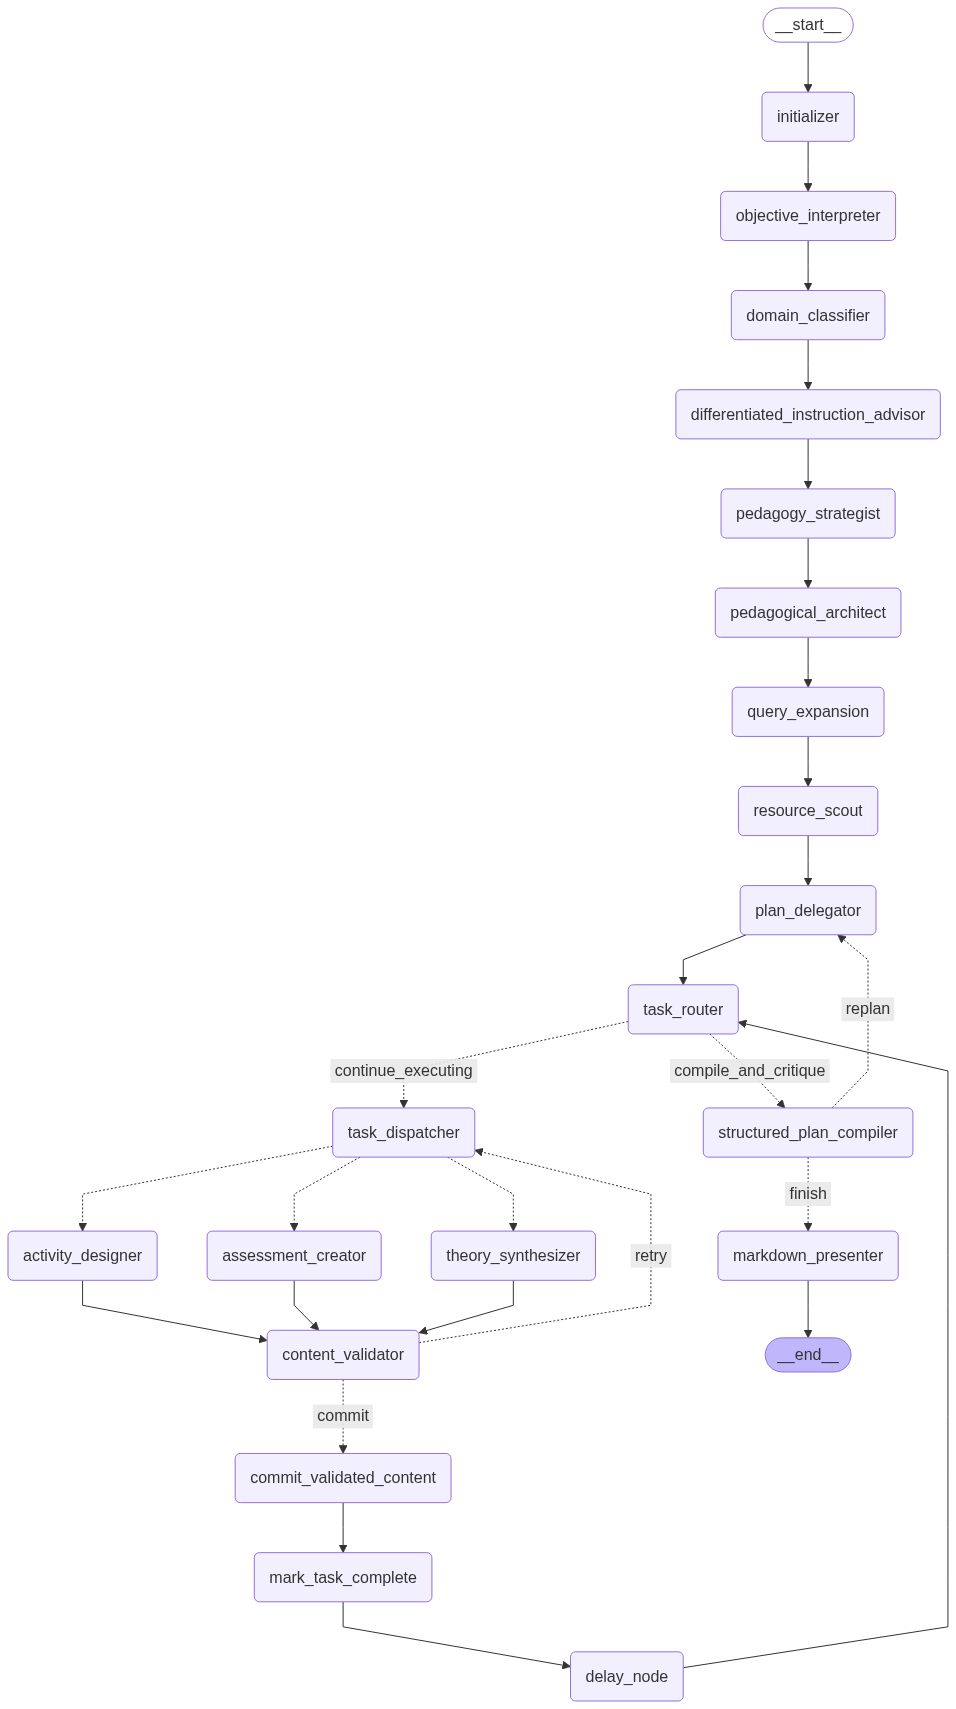

In [43]:
# ==============================================================================
# CELL 4.4: HIỂN THỊ SƠ ĐỒ GRAPH (TÙY CHỌN)
# ==============================================================================
try:
    # Lệnh này sẽ vẽ một sơ đồ của workflow, rất hữu ích để gỡ lỗi
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Lỗi vẽ biểu đồ: {e}. Đây là lỗi không nghiêm trọng, bạn vẫn có thể chạy quy trình.")

## PHẦN 5

In [44]:
# ==============================================================================
# CELL 5.1: ĐỊNH NGHĨA HÀM CHẠY QUY TRÌNH
# ==============================================================================
async def run_architect(user_request: str):
    if 'llm' not in globals() or llm is None:
        print_warning("LLM chưa được khởi tạo. Vui lòng chạy lại Cell 1.3.")
        return
    if 'vector_store' not in globals() or vector_store is None:
        print_warning("Kho tri thức chưa được tải. Vui lòng chạy lại Cell 1.4.")
        return
    if 'app' not in globals():
        print_warning("Graph 'app' chưa được biên dịch. Vui lòng chạy lại Cell 4.3.")
        return

    initial_state = {"messages": [HumanMessage(content=user_request)]}
    console.print(f"\n[bold magenta]🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:[/bold magenta]\n> {user_request}")
    config = {"recursion_limit": 150} 
    
    final_state_result = None
    try:
        async for event in app.astream(initial_state, config=config):
            for node_name, node_output in event.items():
                console.print(f"\n[bold yellow]------- Hoàn thành bước: {node_name} -------[/bold yellow]")
                final_state_result = node_output

        console.print("\n[bold magenta]🏁 KẾT THÚC QUY TRÌNH V7.1.[/bold magenta]")
        
        if final_state_result and final_state_result.get("final_markdown_plan"):
            console.print("\n[bold green]📝 GIÁO ÁN HOÀN CHỈNH (v9.0)[/bold green]")
            console.print(Markdown(final_state_result["final_markdown_plan"]))
            
            # (Tùy chọn) In ra cả JSON để kiểm tra
            if VERBOSE_MODE:
                print_result(final_state_result.get("final_structured_plan"), "Output JSON có cấu trúc")

        else:
            print_warning("Không tạo được giáo án cuối cùng. Có thể Critic đã yêu cầu làm lại nhưng hết giới hạn đệ quy.")
            print("\nTrạng thái cuối cùng để gỡ lỗi:")
            pprint(final_state_result)
            
    except Exception as e:
        print_warning(f"Đã xảy ra lỗi nghiêm trọng trong quá trình chạy graph: {e}")
        import traceback
        traceback.print_exc()

print("✅ Hàm `run_architect` đã sẵn sàng để sử dụng.")

✅ Hàm `run_architect` đã sẵn sàng để sử dụng.


In [45]:
# ==============================================================================
# CELL 5.2: KÍCH HOẠT CHẠY THỬ NGHIỆM
# ==============================================================================
# Yêu cầu để kiểm tra
architect_request = "Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao."
VERBOSE_MODE = True 

# Chạy quy trình đã được cải cách
# Lưu ý: bạn cần một môi trường hỗ trợ `await` ở cấp độ cao nhất (như Jupyter Notebook)
await run_architect(architect_request)

🚀 BẮT ĐẦU QUY TRÌNH V7.1 (THE ARCHITECT) VỚI YÊU CẦU:
> Soạn giúp tôi giáo án bài 'Đường tròn ngoại tiếp và đường tròn nội tiếp' cho học sinh lớp 9 trong 90 phút. Đây là
một lớp học khá yếu, các em thường mất tập trung và cần các hoạt động có tính tương tác cao.

> `Initializer`: Đang khởi tạo trạng thái và lấy yêu cầu gốc...

------- Hoàn thành bước: initializer -------

> `Agent: Objective Interpreter` (v7.5) đang phân tích mục tiêu...

✔️ Mục tiêu & Ràng buộc đã phân tích:

{
│   'action_verb': 'Soạn',
│   'bloom_level': 2,
│   'topic': 'Đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'grade_level': 'Lớp 9',
│   'constraints': {
│   │   'duration_minutes': 90
│   }
}

------- Hoàn thành bước: objective_interpreter -------

> `Agent: Domain Classifier` (v7.5) đang xác định lĩnh vực chuyên môn...

✔️ Lĩnh vực chuyên môn được xác định:

'Toán học'

------- Hoàn thành bước: domain_classifier -------

> `Agent: Differentiated Instruction Advisor` (v9.1) đang phân tích và đề xuất chiến lược phân hóa...

✔️ Hồ sơ lớp học và Chiến lược Phân hóa:

{
│   'learning_pace': 'chậm',
│   'engagement_style': 'thụ động',
│   'special_notes': 'Lớp học khá yếu, học sinh dễ mất tập trung, cần các hoạt động tương tác cao để duy trì sự chú ý.',
│   'differentiation_strategy': {
│   │   'for_struggling_students': 'Chia nhỏ kiến thức thành các phần nhỏ, sử dụng nhiều ví dụ trực quan và hình ảnh minh họa. Cung cấp phiếu bài tập có gợi ý từng bước hoặc công thức áp dụng. Tăng cường hoạt động nhóm đôi/nhóm nhỏ để học sinh yếu có thể nhận được sự hỗ trợ từ bạn bè và giáo viên. Thường xuyên kiểm tra nhanh sự hiểu bài bằng các câu hỏi trắc nghiệm đơn giản hoặc giơ tay.',
│   │   'for_advanced_students': 'Giao các bài tập nâng cao có tính tổng hợp hoặc yêu cầu chứng minh. Khuyến khích học sinh khá giỏi tự tìm hiểu thêm các ứng dụng thực tế của đường tròn ngoại tiếp/nội tiếp (ví dụ: trong kiến trúc, thiết kế). Yêu cầu các em giải thích lại kiến thức cho các bạn trong nhóm hoặc chuẩn bị một phần trình bày ngắn gọn về một khía cạnh nâng cao của bài học.'
│   }
}

------- Hoàn thành bước: differentiated_instruction_advisor -------

> `Agent: Pedagogy Strategist` (v7.5) đang xây dựng chiến lược sư phạm chi tiết...

✔️ Chiến lược sư phạm chi tiết:

{
│   'name': 'Dạy học hợp tác (Cooperative Learning)',
│   'rationale': 'Phương pháp Dạy học hợp tác rất phù hợp với đặc điểm của lớp học này. Nó giúp khắc phục tính thụ động và dễ mất tập trung của học sinh bằng cách khuyến khích sự tương tác cao giữa các thành viên trong nhóm. Học sinh yếu sẽ nhận được sự hỗ trợ trực tiếp từ bạn bè và giáo viên, trong khi học sinh khá giỏi có cơ hội củng cố kiến thức bằng cách giải thích cho người khác. Việc chia nhỏ kiến thức và giao nhiệm vụ theo nhóm cũng giúp giảm áp lực, tạo môi trường học tập tích cực và hiệu quả hơn cho một lớp có nhịp độ học chậm.',
│   'key_actions': [
│   │   'Khởi động và giới thiệu vấn đề bài học một cách trực quan, hấp dẫn.',
│   │   'Tổ chức lớp học thành các nhóm nhỏ (3-4 học sinh) một cách linh hoạt, đảm bảo mỗi nhóm có sự đa dạng về năng lực.',
│   │   'Giao nhiệm vụ học tập cụ thể cho từng nhóm, chia nhỏ kiến thức về đường tròn ngoại tiếp và nội tiếp thành các phần dễ tiếp cận (ví dụ: khám phá định nghĩa, tính chất, cách vẽ, ứng dụng qua các bài tập có gợi ý).',
│   │   'Học sinh làm việc nhóm, thảo luận, hỗ trợ lẫn nhau để hoàn thành nhiệm vụ dưới sự hướng dẫn và giám sát chặt chẽ của giáo viên.',
│   │   'Đại diện các nhóm trình bày kết quả, chia sẻ cách giải quyết vấn đề hoặc những phát hiện của nhóm mình.',
│   │   'Giáo viên tổng kết, chuẩn hóa kiến thức, giải đáp thắc mắc và nhấn mạnh các điểm trọng tâm của bài học.',
│   │   'Củng cố kiến thức bằng các bài tập luyện tập cá nhân hoặc trò chơi tương tác nhanh để kiểm tra sự hiểu bài và duy trì sự tập trung.'
│   ]
}

------- Hoàn thành bước: pedagogy_strategist -------

> `Agent: Pedagogical Architect` (v7.5) đang thiết kế kịch bản buổi học...

✔️ Bản thiết kế Sư phạm đã được tạo:

[
│   "Khởi động và Khám phá vấn đề: Giáo viên sử dụng hình ảnh, video hoặc vật thật (ví dụ: một miếng bìa hình tam giác và một sợi dây) để tạo tình huống có vấn đề, đặt câu hỏi gợi mở về việc 'vẽ một đường tròn đi qua ba đỉnh của tam giác' hoặc 'vẽ một đường tròn tiếp xúc với ba cạnh của tam giác'. Chia lớp thành các nhóm nhỏ ngay từ đầu để học sinh bắt đầu thảo luận, suy đoán ban đầu.",
│   'Xây dựng kiến thức: Đường tròn ngoại tiếp: Giáo viên phát phiếu học tập có hướng dẫn cụ thể cho từng nhóm. Nhiệm vụ bao gồm vẽ các đường trung trực của tam giác, xác định giao điểm và vẽ đường tròn đi qua ba đỉnh. Học sinh thảo luận, ghi nhận kết quả. Giáo viên quan sát, hỗ trợ, gợi ý khi cần thiết, đặc biệt với các nhóm yếu.',
│   'Xây dựng kiến thức: Đường tròn nội tiếp: Tiếp tục hoạt động nhóm với phiếu học tập mới tập trung vào đường tròn nội tiếp. Nhiệm vụ bao gồm vẽ các đường phân giác của tam giác, xác định giao điểm và vẽ đường tròn tiếp xúc với ba cạnh. Khuyến khích các nhóm so sánh điểm giống và khác nhau giữa đường tròn ngoại tiếp và nội tiếp. Giáo viên tiếp tục hỗ trợ và chuẩn hóa kiến thức sau khi các nhóm hoàn thành.',
│   'Luyện tập và Vận dụng: Giáo viên cung cấp bộ bài tập đa dạng (có phân hóa) cho các nhóm. Các bài tập bao gồm tính toán bán kính, xác định vị trí tâm, chứng minh tính chất. Học sinh yếu được khuyến khích sử dụng gợi ý, công thức. Học sinh khá giỏi được giao các bài tập tổng hợp hoặc yêu cầu chứng minh. Đại diện các nhóm trình bày cách giải, giáo viên nhận xét và chuẩn hóa lời giải.',
│   "Tổng kết và Củng cố: Giáo viên tổng kết lại các kiến thức trọng tâm của bài học (định nghĩa, tính chất, cách xác định tâm, bán kính của cả hai loại đường tròn). Tổ chức một trò chơi nhỏ hoặc chuỗi câu hỏi trắc nghiệm nhanh (ví dụ: 'Ai nhanh hơn?') để kiểm tra sự hiểu bài và duy trì sự tập trung. Giao bài tập về nhà có phân hóa để học sinh tự luyện tập thêm."
]

------- Hoàn thành bước: pedagogical_architect -------

> `Agent: Query Expansion` (v7.5) đang phân tích yêu cầu...

✔️ Các truy vấn tìm kiếm đã được mở rộng:

[
│   'đường tròn ngoại tiếp và đường tròn nội tiếp',
│   'công thức đường tròn ngoại tiếp tam giác',
│   'công thức đường tròn nội tiếp tam giác',
│   'tính bán kính đường tròn ngoại tiếp',
│   'tính bán kính đường tròn nội tiếp',
│   'bài tập đường tròn ngoại tiếp nội tiếp lớp 9',
│   'chuyên đề đường tròn ngoại tiếp và nội tiếp',
│   'lý thuyết đường tròn ngoại tiếp và nội tiếp',
│   'ứng dụng đường tròn ngoại tiếp trong hình học',
│   'ứng dụng đường tròn nội tiếp trong hình học',
│   'đường tròn ngoại tiếp tam giác vuông',
│   'đường tròn nội tiếp tam giác đều',
│   'tâm đường tròn ngoại tiếp là gì',
│   'tâm đường tròn nội tiếp là gì',
│   'quan hệ giữa đường tròn ngoại tiếp và nội tiếp',
│   'phương pháp giải bài tập đường tròn ngoại tiếp',
│   'phương pháp giải bài tập đường tròn nội tiếp',
│   'đường tròn ngoại tiếp tứ giác',
│   'đường tròn nội tiếp tứ giác',
│   'ôn thi đường tròn ngoại tiếp nội tiếp'
]

------- Hoàn thành bước: query_expansion -------

> `Agent: Resource Scout` (v8.1 - Sửa lỗi) đang tìm kiếm và sàng lọc...

> Tìm thấy 100 tài liệu, sàng lọc còn 8 đoạn văn bản độc nhất.

✔️ Tài liệu RAG cuối cùng:

{
│   'source': 'Sách giáo khoa (từ RAG - đã sàng lọc)',
│   'summary': 'Chào các em học sinh,\n\nVới vai trò là một giáo viên, thầy/cô đã đọc kỹ các đoạn văn bản được cung cấp và xin tổng hợp kiến thức cốt lõi về chủ đề "Đường tròn ngoại tiếp và đường tròn nội tiếp" dựa **chỉ** vào những thông tin này.\n\n**TÓM TẮT KIẾN THỨC CỐT LÕI VỀ CHỦ ĐỀ "ĐƯỜNG TRÒN NGOẠI TIẾP VÀ ĐƯỜNG TRÒN NỘI TIẾP"**\n\nDựa trên các đoạn văn bản đã cho, kiến thức cốt lõi có thể tổng hợp được như sau:\n\n**I. Về Đường tròn nội tiếp (liên quan đến khái niệm tiếp tuyến)**\n\nMặc dù các đoạn văn bản không trực tiếp định nghĩa "đường tròn nội tiếp", nhưng chúng cung cấp các khái niệm và tính chất quan trọng về "tiếp tuyến" của đường tròn. Khái niệm tiếp tuyến là yếu tố cốt lõi để hiểu về đường tròn nội tiếp (đường tròn nội tiếp là đường tròn tiếp xúc với các cạnh của đa giác).\n\n1.  **Định nghĩa Tiếp tuyến và Tiếp điểm:**\n    *   Đường thẳng và đường tròn được gọi là **tiếp xúc với nhau** nếu chúng có đúng một điểm chung.\n    *   Điểm chung duy nhất đó được gọi là **tiếp điểm**.\n    *   Khi đó, đường thẳng đó còn được gọi là **tiếp tuyến** của đường tròn tại tiếp điểm.\n\n2.  **Dấu hiệu nhận biết Tiếp tuyến của đường tròn:**\n    *   Nếu một đường thẳng đi qua một điểm trên một đường tròn và vuông góc với bán kính đi qua điểm đó, thì đường thẳng ấy là một tiếp tuyến của đường tròn.\n\n3.  **Mối quan hệ giữa khoảng cách từ tâm đến tiếp tuyến và bán kính:**\n    *   Khi một đường thẳng là tiếp tuyến của đường tròn (O; R), khoảng cách (d) từ tâm O đến đường thẳng đó bằng bán kính R (tức là $d = R$).\n\n**II. Về Đường tròn ngoại tiếp**\n\nCác đoạn văn bản được cung cấp không chứa thông tin hay định nghĩa nào về "đường tròn ngoại tiếp". Do đó, không thể tổng hợp kiến thức về phần này dựa trên tài liệu đã cho.\n\n---\nHy vọng bản tóm tắt này giúp các em nắm vững những kiến thức cơ bản được đề cập trong tài liệu.'
}

------- Hoàn thành bước: resource_scout -------

> `Agent: Plan Delegator` (v8.2 - Siêu cụ thể) đang triển khai Bản thiết kế...

✔️ Đã tạo 5 nhiệm vụ chi tiết:

[
│   {
│   │   'task_id': 0,
│   │   'task_name': 'Khám phá vấn đề: Đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': 'Học sinh quan sát hình ảnh, video hoặc vật thật (ví dụ: miếng bìa hình tam giác và sợi dây), thảo luận nhóm để đưa ra các suy đoán ban đầu về cách vẽ một đường tròn đi qua ba đỉnh của tam giác hoặc tiếp xúc với ba cạnh của tam giác.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 1,
│   │   'task_name': 'Xây dựng kiến thức: Xác định và vẽ Đường tròn ngoại tiếp',
│   │   'task_description': 'Theo hướng dẫn trên phiếu học tập, học sinh vẽ các đường trung trực của tam giác, xác định giao điểm của chúng (tâm đường tròn ngoại tiếp), và vẽ đường tròn đi qua ba đỉnh của tam giác. Học sinh thảo luận nhóm để ghi nhận các bước thực hiện và kết quả.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 2,
│   │   'task_name': 'Xây dựng kiến thức: Xác định và vẽ Đường tròn nội tiếp',
│   │   'task_description': 'Tiếp tục với phiếu học tập mới, học sinh vẽ các đường phân giác của tam giác, xác định giao điểm của chúng (tâm đường tròn nội tiếp), và vẽ đường tròn tiếp xúc với ba cạnh của tam giác. Học sinh so sánh điểm giống và khác nhau giữa đường tròn ngoại tiếp và nội tiếp.',
│   │   'estimated_duration': 25,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 3,
│   │   'task_name': 'Luyện tập và Vận dụng: Giải bài tập về Đường tròn ngoại tiếp và nội tiếp',
│   │   'task_description': 'Học sinh làm việc nhóm để giải các bài tập đa dạng (bao gồm tính toán bán kính, xác định vị trí tâm, chứng minh tính chất) liên quan đến đường tròn ngoại tiếp và nội tiếp. Đại diện các nhóm trình bày cách giải và nhận phản hồi từ giáo viên và các nhóm khác.',
│   │   'estimated_duration': 15,
│   │   'status': 'pending'
│   },
│   {
│   │   'task_id': 4,
│   │   'task_name': 'Tổng kết và Củng cố kiến thức',
│   │   'task_description': 'Học sinh tham gia trò chơi nhỏ hoặc chuỗi câu hỏi trắc nghiệm nhanh để kiểm tra sự hiểu bài về định nghĩa, tính chất, cách xác định tâm và bán kính của đường tròn ngoại tiếp và nội tiếp. Học sinh ghi nhận bài tập về nhà có phân hóa để tự luyện tập thêm.',
│   │   'estimated_duration': 10,
│   │   'status': 'pending'
│   }
]

------- Hoàn thành bước: plan_delegator -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Khám phá vấn đề: Đường tròn ngoại tiếp và nội tiếp' (ID: 0)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Khám phá vấn đề: Đường tròn ngoại tiếp và nội tiếp',
│   'description': 'Học sinh làm việc theo nhóm (3-4 người). Mỗi nhóm sẽ được cung cấp các hình ảnh, video minh họa hoặc vật thật (ví dụ: một miếng bìa hình tam giác, compa, thước kẻ, sợi dây). Nhiệm vụ của nhóm là:\n1. Quan sát kỹ các tài liệu được cung cấp.\n2. Thảo luận và đưa ra các suy đoán ban đầu về cách để vẽ một đường tròn đi qua ba đỉnh của tam giác (đường tròn ngoại tiếp).\n3. Thảo luận và đưa ra các suy đoán ban đầu về cách để vẽ một đường tròn tiếp xúc với ba cạnh của tam giác (đường tròn nội tiếp).\n4. Ghi lại các ý tưởng, các bước phỏng đoán và những câu hỏi nảy sinh trong quá trình thảo luận của nhóm vào phiếu học tập.',
│   'duration_minutes': 15,
│   'activity_type': 'Thảo luận nhóm',
│   'teacher_actions': [
│   │   'Chuẩn bị và phân phát các tài liệu học tập (hình ảnh, video, tam giác bìa, compa, thước, sợi dây) cho từng nhóm.',
│   │   'Phân chia học sinh thành các nhóm nhỏ (3-4 học sinh/nhóm).',
│   │   'Giải thích rõ ràng nhiệm vụ và mục tiêu của hoạt động khám phá.',
│   │   'Đi vòng quanh các nhóm, quan sát quá trình thảo luận và lắng nghe các ý tưởng của học sinh.',
│   │   'Đặt câu hỏi gợi mở, khuyến khích học sinh suy nghĩ sâu hơn và chia sẻ ý tưởng.',
│   │   'Ghi nhận các ý tưởng nổi bật hoặc các câu hỏi thường gặp của học sinh để chuẩn bị cho phần giới thiệu kiến thức mới.',
│   │   'Yêu cầu đại diện một số nhóm trình bày nhanh ý tưởng ban đầu của nhóm mình.'
│   ],
│   'solution_guide': 'Các câu hỏi gợi mở cho học sinh:\n- Để vẽ một đường tròn đi qua ba đỉnh của tam giác, tâm của đường tròn đó phải có tính chất gì đối với ba đỉnh đó?\n- Để vẽ một đường tròn tiếp xúc với ba cạnh của tam giác, tâm của đường tròn đó phải có tính chất gì đối với ba cạnh đó?\n- Các bạn có thể sử dụng dụng cụ nào (compa, thước, dây) để kiểm tra ý tưởng của mình?',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp các tam giác bìa đã được đánh dấu sẵn một số điểm đặc biệt (ví dụ: trung điểm các cạnh, giao điểm các đường trung trực/phân giác) để gợi ý về vị trí tâm. Đặt các câu hỏi trực tiếp hơn như: 'Để đường tròn đi qua 3 đỉnh, tâm của nó phải cách đều những điểm nào?' hoặc 'Để đường tròn tiếp xúc 3 cạnh, tâm của nó phải cách đều những đường nào?'",
│   │   'for_advanced_students': "Thử thách học sinh suy nghĩ về tính duy nhất của các đường tròn này: 'Có bao nhiêu đường tròn có thể đi qua ba đỉnh của một tam giác? Tại sao?' hoặc 'Có phải mọi tam giác đều có đường tròn ngoại tiếp và nội tiếp không? Giải thích.' Khuyến khích các em suy nghĩ về cách chứng minh các suy đoán của mình."
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v7.5) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> ...Đang nghỉ 2 giây để tránh vượt rate limit...

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Xây dựng kiến thức: Xác định và vẽ Đường tròn ngoại tiếp' (ID: 1)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Xây dựng kiến thức: Xác định và vẽ Đường tròn ngoại tiếp',
│   'description': 'Theo hướng dẫn trên phiếu học tập, học sinh vẽ các đường trung trực của tam giác, xác định giao điểm của chúng (tâm đường tròn ngoại tiếp), và vẽ đường tròn đi qua ba đỉnh của tam giác. Học sinh thảo luận nhóm để ghi nhận các bước thực hiện và kết quả.',
│   'duration_minutes': 25,
│   'activity_type': 'Thực hành nhóm',
│   'teacher_actions': [
│   │   'Phát phiếu học tập và dụng cụ học tập (thước, compa) cho từng nhóm.',
│   │   'Hướng dẫn chung về mục tiêu và các bước thực hiện hoạt động.',
│   │   'Quan sát các nhóm làm việc, kịp thời hỗ trợ khi học sinh gặp khó khăn.',
│   │   'Đặt câu hỏi gợi mở để học sinh tự khám phá và ghi nhận kiến thức.',
│   │   'Kiểm tra nhanh sự hiểu bài của các nhóm bằng cách yêu cầu trình bày ngắn gọn các bước đã thực hiện.',
│   │   'Tổng kết hoạt động, chốt lại kiến thức về tâm và cách vẽ đường tròn ngoại tiếp tam giác.'
│   ],
│   'solution_guide': 'Phiếu học tập sẽ bao gồm các bước sau:\n1. Vẽ một tam giác ABC bất kỳ.\n2. Dùng thước và compa, vẽ đường trung trực của cạnh AB.\n3. Dùng thước và compa, vẽ đường trung trực của cạnh BC.\n4. Dùng thước và compa, vẽ đường trung trực của cạnh CA.\n5. Xác định giao điểm của ba đường trung trực (gọi là O).\n6. Dùng compa đặt tâm tại O, mở khẩu độ bằng khoảng cách từ O đến một đỉnh của tam giác (ví dụ OA), vẽ đường tròn. Kiểm tra xem đường tròn có đi qua cả ba đỉnh A, B, C không.\n7. Thảo luận nhóm và ghi lại nhận xét: Giao điểm của ba đường trung trực có tính chất gì? Đường tròn vừa vẽ có tên gọi là gì?',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp phiếu học tập có sẵn một tam giác mẫu và các bước vẽ đường trung trực được chia nhỏ, có hình ảnh minh họa từng bước. Giáo viên có thể trực tiếp hướng dẫn lại cách sử dụng compa và thước để vẽ đường trung trực cho nhóm này. Đặt các câu hỏi đơn giản như 'Giao điểm của ba đường trung trực có đặc điểm gì?' để giúp các em ghi nhớ.",
│   │   'for_advanced_students': 'Yêu cầu học sinh chứng minh tại sao giao điểm của ba đường trung trực lại cách đều ba đỉnh của tam giác. Gợi ý các em thử vẽ đường tròn ngoại tiếp cho các loại tam giác đặc biệt (tam giác vuông, tam giác tù) và nhận xét về vị trí của tâm đường tròn ngoại tiếp. Khuyến khích các em giải thích lại các bước vẽ cho các bạn trong nhóm.'
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v7.5) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> ...Đang nghỉ 2 giây để tránh vượt rate limit...

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Xây dựng kiến thức: Xác định và vẽ Đường tròn nội tiếp' (ID: 2)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Xây dựng kiến thức: Xác định và vẽ Đường tròn nội tiếp',
│   'description': 'Học sinh sẽ thực hiện các bước sau trên phiếu học tập đã được phát:\n1.  Vẽ một tam giác bất kỳ (hoặc sử dụng tam giác đã cho sẵn trên phiếu).\n2.  Sử dụng thước và compa để vẽ ba đường phân giác của các góc trong tam giác.\n3.  Xác định giao điểm của ba đường phân giác. Đây chính là tâm của đường tròn nội tiếp (tâm I).\n4.  Từ tâm I, vẽ một đường vuông góc xuống một cạnh của tam giác để xác định bán kính đường tròn nội tiếp (r).\n5.  Dùng compa vẽ đường tròn tâm I, bán kính r. Quan sát xem đường tròn này có tiếp xúc với cả ba cạnh của tam giác hay không.\n6.  So sánh điểm giống và khác nhau giữa đường tròn ngoại tiếp (đã học ở hoạt động trước) và đường tròn nội tiếp về: tâm, bán kính, vị trí tương đối với tam giác, và cách xác định.',
│   'duration_minutes': 25,
│   'activity_type': 'Thực hành vẽ hình và so sánh',
│   'teacher_actions': [
│   │   'Phát phiếu học tập có sẵn các tam giác mẫu hoặc yêu cầu học sinh tự vẽ tam giác.',
│   │   'Hướng dẫn lại cách vẽ đường phân giác của một góc bằng compa và thước thẳng nếu cần.',
│   │   'Đi vòng quanh lớp quan sát, hỗ trợ cá nhân hoặc nhóm nhỏ khi học sinh gặp khó khăn trong việc vẽ hình hoặc xác định tâm/bán kính.',
│   │   'Kiểm tra nhanh các hình vẽ của học sinh, đưa ra phản hồi kịp thời.',
│   │   'Gợi ý các câu hỏi để học sinh so sánh hai loại đường tròn (ngoại tiếp và nội tiếp).',
│   │   'Yêu cầu một vài học sinh trình bày kết quả và nhận xét của mình trước lớp.'
│   ],
│   'solution_guide': 'Các điểm cần lưu ý khi hướng dẫn học sinh:\n-   **Vẽ đường phân giác:** Đảm bảo học sinh dùng compa đúng cách để chia đôi góc.\n-   **Xác định tâm I:** Giao điểm của ba đường phân giác phải trùng nhau. Nếu không, cần kiểm tra lại các bước vẽ.\n-   **Xác định bán kính r:** Bán kính là khoảng cách từ tâm I đến một cạnh của tam giác (phải là đoạn vuông góc). Học sinh có thể vẽ đường vuông góc từ I xuống một cạnh bất kỳ.\n-   **So sánh:**\n    -   **Giống nhau:** Đều là đường tròn liên quan đến tam giác, đều có tâm và bán kính.\n    -   **Khác nhau:**\n        -   **Tâm:** Ngoại tiếp là giao 3 đường trung trực; Nội tiếp là giao 3 đường phân giác.\n        -   **Vị trí tâm:** Ngoại tiếp có thể nằm trong, trên, hoặc ngoài tam giác; Nội tiếp luôn nằm trong tam giác.\n        -   **Tiếp xúc/Đi qua:** Ngoại tiếp đi qua 3 đỉnh; Nội tiếp tiếp xúc với 3 cạnh.\n        -   **Bán kính:** Bán kính ngoại tiếp là khoảng cách từ tâm đến đỉnh; Bán kính nội tiếp là khoảng cách từ tâm đến cạnh (vuông góc).',
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp phiếu học tập có sẵn các tam giác đã được vẽ, hoặc thậm chí có sẵn một đường phân giác để học sinh chỉ cần vẽ thêm hai đường còn lại. Đưa ra một checklist các bước vẽ chi tiết kèm hình ảnh minh họa nhỏ. Gợi ý cụ thể các câu hỏi so sánh như: 'Tâm đường tròn ngoại tiếp là giao của đường gì? Tâm đường tròn nội tiếp là giao của đường gì?'",
│   │   'for_advanced_students': "Yêu cầu học sinh chứng minh tại sao giao điểm của ba đường phân giác lại cách đều ba cạnh của tam giác (tức là tâm đường tròn nội tiếp). Đặt câu hỏi mở rộng: 'Liệu có trường hợp nào đường tròn nội tiếp và ngoại tiếp có cùng tâm không? Nếu có thì đó là loại tam giác nào?'"
│   }
}

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v7.5) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> ...Đang nghỉ 2 giây để tránh vượt rate limit...

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Luyện tập và Vận dụng: Giải bài tập về Đường tròn ngoại tiếp và nội tiếp' (ID: 3)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `activity_designer`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Activity Designer` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Activity Designer tạo ra (có phân hóa):

{
│   'activity_name': 'Luyện tập và Vận dụng: Giải bài tập về Đường tròn ngoại tiếp và nội tiếp',
│   'description': 'Học sinh được chia thành các nhóm (4-5 học sinh/nhóm). Mỗi nhóm sẽ nhận một phiếu bài tập gồm các dạng bài khác nhau về đường tròn ngoại tiếp và nội tiếp. Các dạng bài tập bao gồm: 1. Bài tập cơ bản: Tính bán kính đường tròn ngoại tiếp hoặc nội tiếp của các tam giác đặc biệt (tam giác vuông, tam giác đều, tam giác cân) khi biết các yếu tố về cạnh hoặc góc. Ví dụ: Cho tam giác ABC vuông tại A có AB = 6cm, AC = 8cm. Tính bán kính đường tròn ngoại tiếp và nội tiếp tam giác ABC. 2. Bài tập tổng hợp: Xác định vị trí tâm đường tròn ngoại tiếp/nội tiếp trong các trường hợp cụ thể, hoặc tính toán các yếu tố liên quan khi tam giác không phải là tam giác đặc biệt. Ví dụ: Cho tam giác ABC có ba cạnh a, b, c. Chứng minh công thức tính bán kính đường tròn nội tiếp r = S/p (với S là diện tích, p là nửa chu vi). 3. Bài tập nâng cao/chứng minh: Chứng minh các tính chất liên quan đến đường tròn ngoại tiếp/nội tiếp và các yếu tố khác của tam giác (ví dụ: đường cao, đường trung tuyến). Ví dụ: Cho tam giác ABC nội tiếp đường tròn (O). Gọi H là trực tâm của tam giác. Chứng minh rằng bán kính đường tròn ngoại tiếp tam giác HBC bằng bán kính đường tròn ngoại tiếp tam giác ABC. Các nhóm sẽ cùng nhau thảo luận, phân công nhiệm vụ và giải quyết các bài tập trong phiếu. Sau thời gian quy định, đại diện các nhóm sẽ lên bảng trình bày một hoặc hai bài tập tiêu biểu mà nhóm đã giải được. Các nhóm khác sẽ lắng nghe, đặt câu hỏi và đưa ra nhận xét. Giáo viên sẽ tổng kết, nhận xét và bổ sung kiến thức.',
│   'duration_minutes': 15,
│   'activity_type': 'Thực hành nhóm và trình bày',
│   'teacher_actions': [
│   │   'Phân chia học sinh thành các nhóm nhỏ (4-5 học sinh/nhóm).',
│   │   'Phát phiếu bài tập đã được chuẩn bị sẵn với các mức độ khó khác nhau cho từng nhóm hoặc cho phép nhóm tự chọn bài.',
│   │   'Quan sát các nhóm làm việc, đi vòng quanh lớp để nắm bắt tình hình và kịp thời hỗ trợ.',
│   │   'Đặt câu hỏi gợi mở, định hướng tư duy cho các nhóm gặp khó khăn mà không đưa ra lời giải trực tiếp.',
│   │   'Kiểm tra nhanh sự hiểu bài của học sinh yếu bằng các câu hỏi đơn giản hoặc yêu cầu các em trình bày lại một phần nhỏ.',
│   │   'Yêu cầu đại diện các nhóm lên trình bày bài giải trên bảng.',
│   │   'Tổ chức cho các nhóm khác đặt câu hỏi và nhận xét về bài giải của nhóm trình bày.',
│   │   'Tổng kết các bài giải, nhận xét về các phương pháp giải khác nhau và bổ sung kiến thức cần thiết.',
│   │   'Giải đáp các thắc mắc của học sinh sau khi các nhóm đã trình bày xong.'
│   ],
│   'solution_guide': "Đối với các bài tập tính toán: Nhắc nhở học sinh kiểm tra lại các công thức tính bán kính đường tròn ngoại tiếp (R = a/2sinA, R = abc/4S) và nội tiếp (r = S/p, r = (p-a)tan(A/2)). Đối với các bài tập chứng minh: Gợi ý học sinh vẽ thêm đường phụ, sử dụng các tính chất của tiếp tuyến, dây cung, góc nội tiếp, hoặc các định lý liên quan đến tam giác. Các câu hỏi gợi mở chung: 'Tâm đường tròn ngoại tiếp là giao điểm của các đường đặc biệt nào trong tam giác?', 'Tâm đường tròn nội tiếp là giao điểm của các đường đặc biệt nào?', 'Mối liên hệ giữa bán kính đường tròn ngoại tiếp/nội tiếp với các cạnh và diện tích của tam giác là gì?'",
│   'differentiation': {
│   │   'for_struggling_students': "Cung cấp phiếu bài tập có các bài toán cơ bản hơn, có sẵn công thức hoặc gợi ý từng bước cụ thể (ví dụ: 'Bước 1: Xác định loại tam giác. Bước 2: Áp dụng công thức R = abc/4S hoặc r = S/p'). Giáo viên chủ động đến các nhóm có học sinh yếu để kiểm tra nhanh sự hiểu bài, đặt câu hỏi gợi mở đơn giản, hoặc hướng dẫn trực tiếp một phần nhỏ của bài toán. Khuyến khích các em hỏi bạn trong nhóm và nhận sự hỗ trợ từ các bạn.",
│   │   'for_advanced_students': "Giao các bài tập nâng cao, yêu cầu chứng minh hoặc bài toán tổng hợp nhiều kiến thức hình học khác. Khuyến khích các em tìm thêm cách giải khác cho cùng một bài toán hoặc mở rộng bài toán bằng cách đặt thêm câu

------- Hoàn thành bước: activity_designer -------

> `Agent: Contextual Critic` (v7.5) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> ...Đang nghỉ 2 giây để tránh vượt rate limit...

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Nhiệm vụ tiếp theo: 'Tổng kết và Củng cố kiến thức' (ID: 4)

------- Hoàn thành bước: task_router -------

> `Agent: Task Dispatcher` (v7.1) Bắt đầu...

> --- 🚚 `Dispatcher`: Giao nhiệm vụ cho `assessment_creator`.

------- Hoàn thành bước: task_dispatcher -------

> `Agent: Assessment Creator` (v9.0) đang tạo nội dung chi tiết và gợi ý phân hóa...

✔️ Nội dung do Assessment Creator tạo ra (có phân hóa):

{
│   'activity_name': 'Tổng kết và Củng cố kiến thức',
│   'question': 'Cho tam giác ABC. Tâm đường tròn ngoại tiếp tam giác ABC là giao điểm của ba đường nào?\nA. Ba đường cao\nB. Ba đường trung tuyến\nC. Ba đường trung trực\nD. Ba đường phân giác',
│   'question_type': 'Trắc nghiệm',
│   'teacher_actions': [
│   │   'Giáo viên chiếu câu hỏi trắc nghiệm lên bảng hoặc phát phiếu bài tập nhanh.',
│   │   'Yêu cầu học sinh suy nghĩ và chọn đáp án đúng trong 1 phút.',
│   │   'Mời 1-2 học sinh trình bày đáp án và giải thích ngắn gọn lý do lựa chọn.',
│   │   'Giáo viên chốt đáp án đúng, giải thích rõ ràng và củng cố kiến thức về định nghĩa tâm đường tròn ngoại tiếp.',
│   │   'Giao bài tập về nhà có phân hóa để học sinh tự luyện tập thêm.'
│   ],
│   'answer': 'C. Ba đường trung trực',
│   'solution_guide': 'Tâm đường tròn ngoại tiếp tam giác là giao điểm của ba đường trung trực của ba cạnh tam giác. Đường trung trực của một đoạn thẳng là đường thẳng vuông góc với đoạn thẳng đó tại trung điểm của nó. Ba đường trung trực của ba cạnh tam giác luôn đồng quy tại một điểm, và điểm đó chính là tâm đường tròn ngoại tiếp tam giác.',
│   'duration_minutes': 10,
│   'differentiation': {
│   │   'for_struggling_students': 'Đối với học sinh gặp khó khăn, giáo viên có thể gợi ý các em xem lại định nghĩa và tính chất trong sách giáo khoa hoặc phiếu tóm tắt kiến thức trước khi trả lời. Có thể cho phép các em thảo luận nhanh với bạn bên cạnh để tìm ra đáp án.',
│   │   'for_advanced_students': "Đối với học sinh khá giỏi, giáo viên có thể đặt câu hỏi mở rộng sau khi học sinh trả lời xong câu hỏi chính: 'Tâm đường tròn nội tiếp tam giác là giao điểm của ba đường nào? Nêu mối liên hệ giữa vị trí tâm đường tròn ngoại tiếp với các loại tam giác đặc biệt (tam giác vuông, tam giác tù, tam giác nhọn)?'"
│   }
}

------- Hoàn thành bước: assessment_creator -------

> `Agent: Contextual Critic` (v7.5) đang phản biện nội dung...

> ✔️ CHUYÊN GIA PHẢN BIỆN: Nội dung hợp lệ!

> ROUTER (Validation): Nội dung được chấp thuận. Chuyển sang bước ghi nhận.

------- Hoàn thành bước: content_validator -------

> `Commiter`: Đang ghi nhận nội dung đã được xác thực...

------- Hoàn thành bước: commit_validated_content -------

------- Hoàn thành bước: mark_task_complete -------

> ...Đang nghỉ 2 giây để tránh vượt rate limit...

------- Hoàn thành bước: delay_node -------

> `Router`: Đang kiểm tra nhiệm vụ...

> Hết nhiệm vụ, chuyển sang node Compiler & Critic.

------- Hoàn thành bước: task_router -------

> `Agent: Structured Plan Compiler` (v9.0) đang tổng hợp giáo án có cấu trúc...

> CRITIC: Kế hoạch hợp lệ! Bắt đầu tổng hợp giáo án dạng JSON...

> ROUTER (Compilation): Critic lớn đã hài lòng. Kết thúc quy trình.

------- Hoàn thành bước: structured_plan_compiler -------

> `Node: Markdown Presenter` (v9.0) đang tạo bản trình bày Markdown...

------- Hoàn thành bước: markdown_presenter -------

🏁 KẾT THÚC QUY TRÌNH V7.1.

📝 GIÁO ÁN HOÀN CHỈNH (v9.0)

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                          GIÁO ÁN BÀI DẠY: ĐƯỜNG TRÒN NGOẠI TIẾP VÀ ĐƯỜNG TRÒN NỘI TIẾP                          ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

                                                I. THÔNG TIN CHUNG                                                 

 • Chủ Đề: Đường tròn ngoại tiếp và đường tròn nội tiếp                                                            
 • Môn Học: Toán học                                                                                               
 • Lớp: Lớp 9                                                                                                      
 • Thời Lượng: 90 phút                                                                                             
 • Phương Pháp Chủ Đạo: Dạy học hợp tác (Cooperative Learning)                                                     
 • Đặc Điểm Lớp Học: Lớp học khá yếu, học sinh dễ mất tập trung, cần các hoạt động tương tác cao để duy trì sự chú 
   ý.                                                                                                              


                                               II. MỤC TIÊU BÀI HỌC                                                

 • Học sinh có thể Soạn kiến thức về Đường tròn ngoại tiếp và đường tròn nội tiếp.                                 
 • Rèn luyện kỹ năng tư duy logic và giải quyết vấn đề.                                                            
 • Phát triển kỹ năng hợp tác và trình bày.                                                                        


                                                   III. CHUẨN BỊ                                                   

 • Giáo Viên: Bảng phụ, máy chiếu, phiếu học tập (nếu có trong hoạt động)                                          
 • Học Sinh: Sách giáo khoa, vở ghi, dụng cụ học tập                                                               


                                              IV. TIẾN TRÌNH BÀI DẠY                                               

                     Hoạt động 1: Khám phá vấn đề: Đường tròn ngoại tiếp và nội tiếp (15 phút)                     

Nhiệm vụ (Mô tả): Học sinh làm việc theo nhóm (3-4 người). Mỗi nhóm sẽ được cung cấp các hình ảnh, video minh họa  
hoặc vật thật (ví dụ: một miếng bìa hình tam giác, compa, thước kẻ, sợi dây). Nhiệm vụ của nhóm là:                

 1 Quan sát kỹ các tài liệu được cung cấp.                                                                         
 2 Thảo luận và đưa ra các suy đoán ban đầu về cách để vẽ một đường tròn đi qua ba đỉnh của tam giác (đường tròn   
   ngoại tiếp).                                                                                                    
 3 Thảo luận và đưa ra các suy đoán ban đầu về cách để vẽ một đường tròn tiếp xúc với ba cạnh của tam giác (đường  
   tròn nội tiếp).                                                                                                 
 4 Ghi lại các ý tưởng, các bước phỏng đoán và những câu hỏi nảy sinh trong quá trình thảo luận của nhóm vào phiếu 
   học tập. Gợi ý Phân hóa:                                                                                        

 • Hỗ trợ (HS yếu): Cung cấp các tam giác bìa đã được đánh dấu sẵn một số điểm đặc biệt (ví dụ: trung điểm các     
   cạnh, giao điểm các đường trung trực/phân giác) để gợi ý về vị trí tâm. Đặt các câu hỏi trực tiếp hơn như: 'Để  
   đường tròn đi qua 3 đỉnh, tâm của nó phải cách đều những điểm nào?' hoặc 'Để đường tròn tiếp xúc 3 cạnh, tâm của
   nó phải cách đều những đường nào?'                                                                              
 • Thử thách (HS giỏi): Thử thách học sin

✔️ Output JSON có cấu trúc:

None